# Exercise 1 - NYC bike-sharing data
The repository https://drive.google.com/drive/folders/1NESuaJ5yGIrAli1TgrpnK5hnoxGsMi3h?usp=sharing contains bike-sharing data provided by New York City, Citi Bike1 sharing system. The data (in csv format) is structured as follows
- Trip duration (in seconds)
- Start Time and date
- Stop Time and date
- Start Station ID, name, latitude and longitude
- End Station ID, name, latitude and longitude
- Bike ID
- User Type (Customer or Subscriber )
- Birth’s Year
- Gender (0=unknown; 1=male; 2=female)

In [1]:
plot_hist <- function(x1, x2=FALSE, colors=c("firebrick1", "steelblue1"), alpha=0.5, density=20, breaks=20, xlab="X", title="", legend=c("","")) {
    colors <- c(adjustcolor(colors[1], alpha.f=alpha), adjustcolor(colors[2], alpha.f=alpha))
    hist(
        x1,
        breaks=breaks, col=colors[1],
        main=title, xlab=xlab
    )
    if (!identical(x2, FALSE)) {
        hist(
            x2,
            breaks=breaks, col=colors[2],
            xlab=xlab, angle=-45,
            add=TRUE
        )
        legend("topright", legend=legend, fill=colors)
    }
}

# TODO: remove function if useless
get_pos <- function (ix, dataframe, transpose=TRUE) {
    if (transpose == TRUE) {
        dataframe <- t(dataframe)
    }
    row <- floor(ix / nrow(dataframe)) + 1
    col <- ix %% ncol(dataframe)
    return(c(row, col))
}

In [2]:
filenames <- list("data/JC-201902-citibike-tripdata.csv", "data/JC-201903-citibike-tripdata.csv", 
                  "data/JC-201904-citibike-tripdata.csv", "data/JC-201905-citibike-tripdata.csv", 
                  "data/JC-201906-citibike-tripdata.csv")

(1) Read the data and import in a data.frame or tibble structure

In [3]:
list_dataframes = list()

i = 1
for (filename in filenames){
    list_dataframes[[i]] <- read.csv(filename)
    i <- i + 1
}

(2) Merge the five data frames in an unique structure

In [4]:
merged_dataframes <- list_dataframes[[1]]

for (i in c(2:length(list_dataframes))) {
    merged_dataframes <- rbind(merged_dataframes, list_dataframes[[i]])
}

(3) Check for missing data and remove it, if any

In [5]:
na_count = sum( is.na(merged_dataframes) )

accepted_rows = c()
if (na_count > 0) {
    for (i in 1:nrow(merged_dataframes)) {
        na_count = sum(is.na(merged_dataframes[i,]))
        if (na_count == 0) {
            accepted_rows <- c(accepted_rows, i)
        }
    }
    merged_dataframes <- merged_dataframes[accepted_rows, ]
} else {
    cat("There are no missing values.")
}

There are no missing values.

(4.1) Compute the average and the median trip duration in minutes

In [6]:
df <- merged_dataframes # I just rename it for simplicity
trip_duration_mean = mean(df[,1]) / 60 # in minutes
trip_duration_median = median(df[,1]) / 60 # in minutes

print(trip_duration_mean)
print(trip_duration_median)

[1] 12.81071
[1] 5.683333


(4.2) Evaluate the minimum and maximum trip duration; does that seem like a plausible value?

In [7]:
trip_duration_max = max(df[,1]) / 60
trip_duration_min = min(df[,1]) / 60

print(trip_duration_max)
print(trip_duration_min)
# the value for the max value is too large, that means that there was some kind of problem when data was taken

[1] 28817
[1] 1.016667


(4.3) Repeat the calculation of the average (and the median) trip duration by excluding trips longer than 3 hours.
Next, evaluate the number of skimmed entries

In [8]:
df_filtered = df[df[,1] <= 3*3600,]
trip_duration_mean = mean(df_filtered[,1])/60
trip_duration_median = median(df_filtered[,1])/60
number_skimmed = nrow(df) - nrow(df_filtered)

print(trip_duration_mean)
print(trip_duration_median)
print(number_skimmed)

[1] 9.223037
[1] 5.666667
[1] 427


(4.4) Plot the distribution of trip duration after the skimming of the previous point

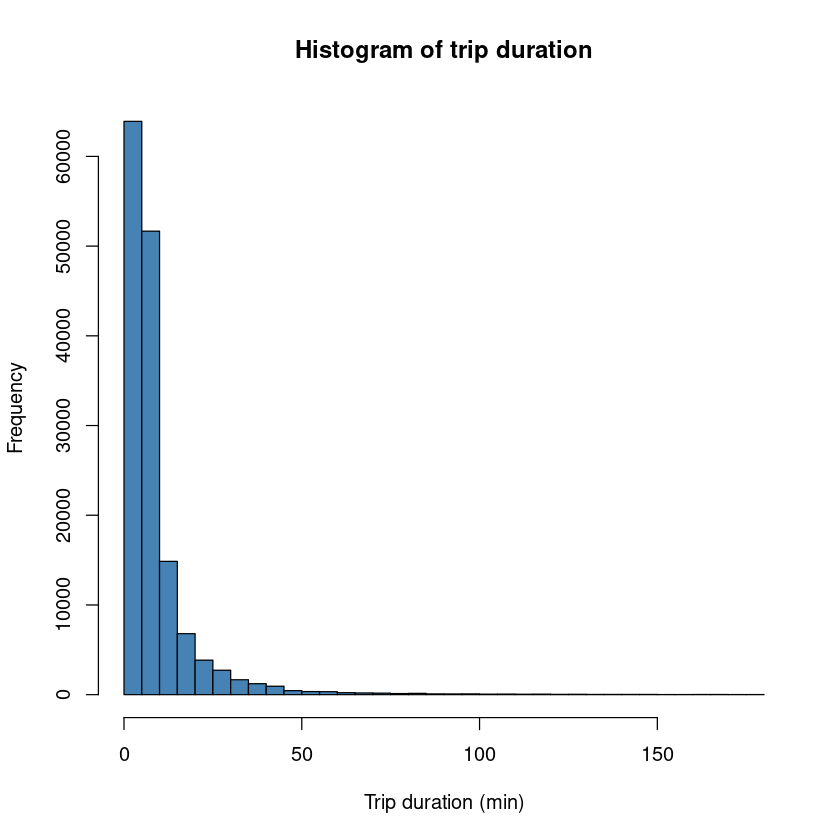

In [9]:
hist(df_filtered[,1]/60, 
     xlab="Trip duration (min)", main="Histogram of trip duration", 
     breaks=nrow(df_filtered)**.3, col="steelblue")

(5) Plot the monthly average trip duration

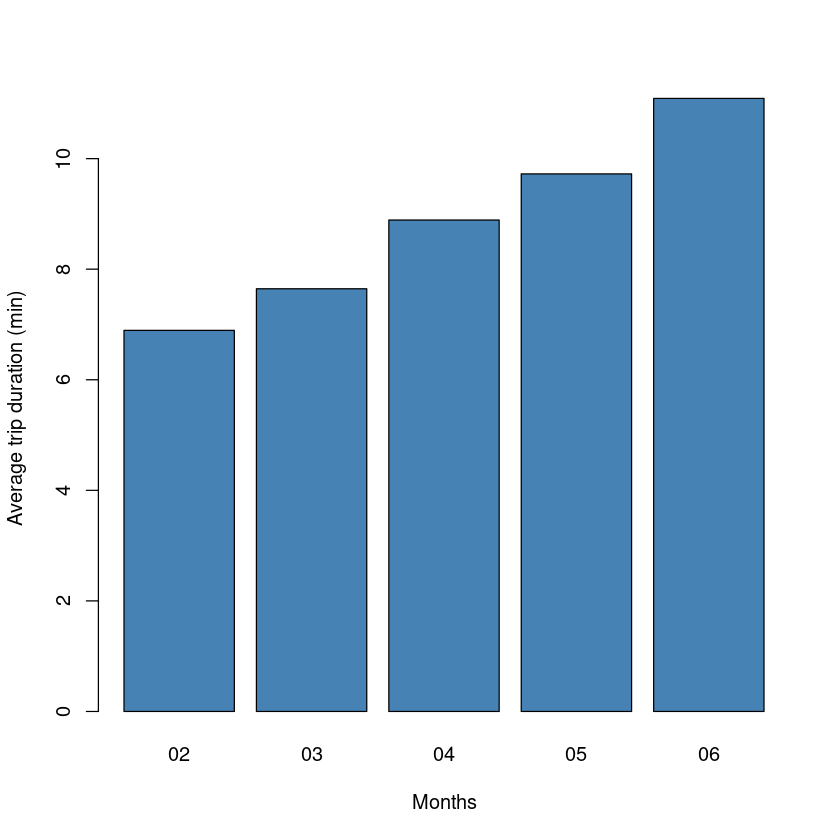

In [10]:
start_time <- as.POSIXct(df_filtered$starttime)
list_months <- format(start_time, "%m")
unique_months <- unique(list_months)

list_means = c()
for (month in unique_months) {
    duration_by_month <- df_filtered$tripduration[list_months == month]
    list_means <- c(list_means, mean(duration_by_month)/60)
}

barplot(list_means, names.arg=unique_months,xlab="Months", ylab="Average trip duration (min)", col="steelblue")

(6.1) Plot the average number of rides per day of the week

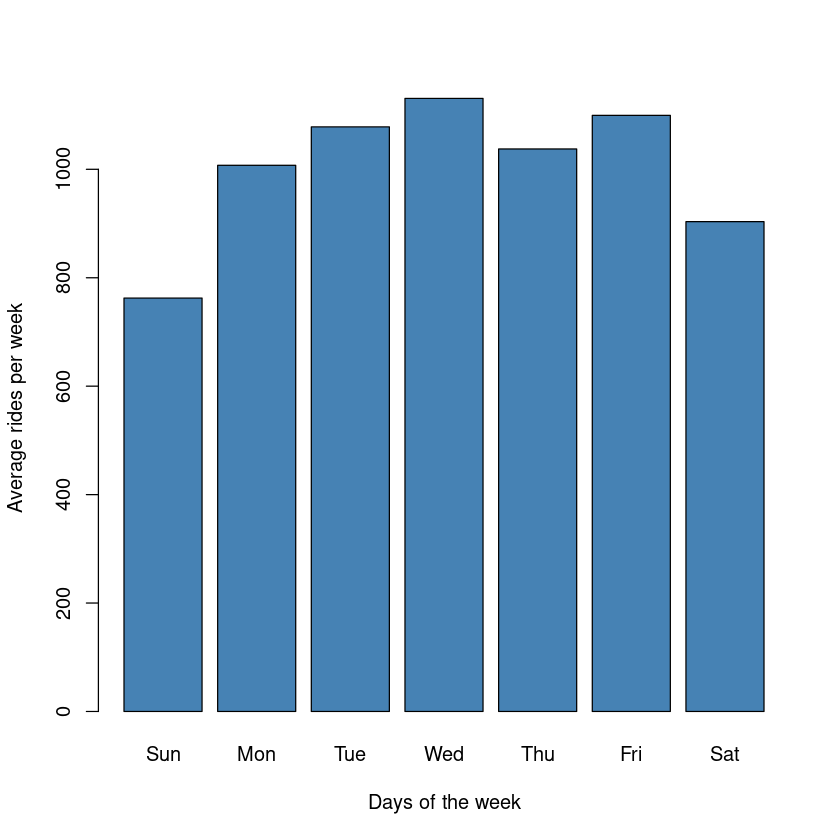

In [11]:
list_days <- format(start_time, "%w")
unique_days <- sort(unique(list_days))
sorted_st <- sort(start_time)
n_weeks <- unclass(sorted_st[length(start_time)]-sorted_st[1]) / 7

average_rides <- c()
for (day in unique_days) {
    avg_rides_per_day <- sum(list_days == day)/n_weeks
    average_rides <- c(average_rides, avg_rides_per_day)
}

name_days = c("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")
barplot(average_rides, names.arg=name_days, xlab="Days of the week", ylab="Average rides per week", col="steelblue")

(6.2) Plot the hourly distribution on weekdays and on weekends

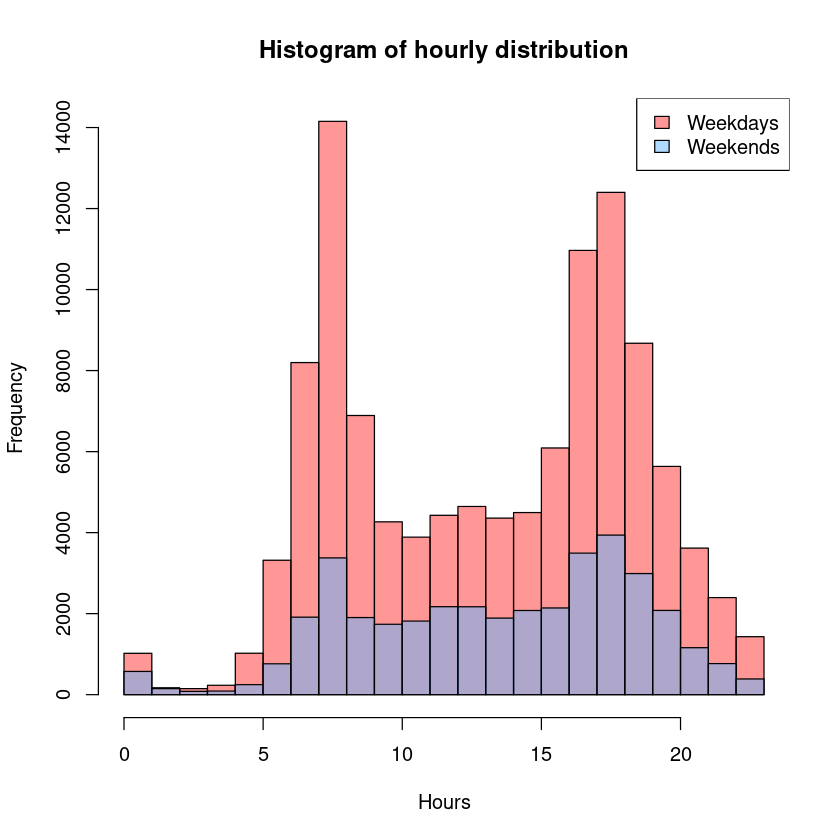

In [12]:
weekdays <- start_time[list_days != '1' & list_days != '0']
weekends <- start_time[list_days == '1' | list_days == '0']

plot_hist(
    as.numeric(format(weekdays, "%H")), 
    as.numeric(format(weekends, "%H")),
    title="Histogram of hourly distribution",
    xlab="Hours",
    legend=c("Weekdays", "Weekends")
)

(6.3) Plot again the average hourly distribution on weekdays but separating customer and subscriber users

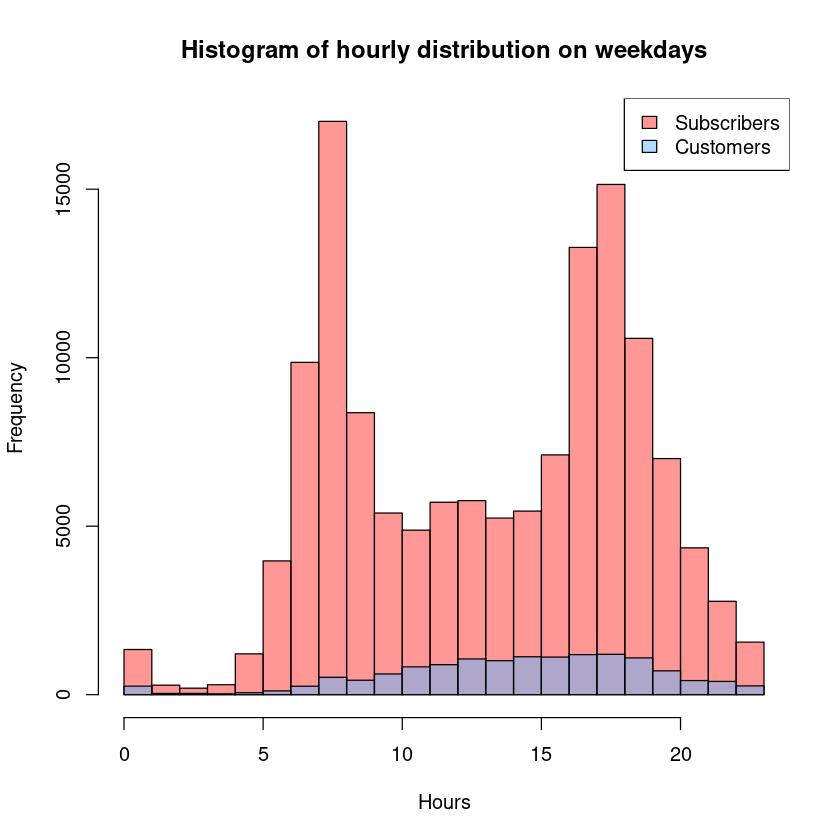

In [13]:
bool_subscribers = df_filtered$usertype == "Subscriber"

bool_weekdays <- list_days != "0" | list_days != "1"
subscribers_weekdays  <- as.POSIXct( df_filtered[bool_weekdays & bool_subscribers,]$starttime )
customers_weekdays  <- as.POSIXct( df_filtered[bool_weekdays & !bool_subscribers,]$starttime )

plot_hist(
    as.numeric(format(subscribers_weekdays, "%H")), 
    as.numeric(format(customers_weekdays, "%H")),
    title="Histogram of hourly distribution on weekdays",
    xlab="Hours",
    legend=c("Subscribers", "Customers")
)

(7.1) Using the latitude and longitude information, evaluate the average speed (in km/h) of a user, discarding the trip lasting longer than 1 hour

In [14]:
short_trips <- df[df$tripduration <= 3600,]

# calculate how much a degree of latitude and longitude equals to in km
earth_radius <- 6378 # km
km_per_degree <- (2 * pi * earth_radius) / 360

delta_latitude <- abs(short_trips$end.station.latitude - short_trips$start.station.latitude)
delta_longitude <- abs(short_trips$end.station.longitude - short_trips$start.station.longitude)
distance <- km_per_degree*(delta_latitude**2 + delta_longitude**2 )**.5

# distance / short_trips$tripduration/3600
speeds <- distance/(short_trips$tripduration/3600)
mean_speed_users <- mean(speeds)
print(mean_speed_users)

[1] 10.6212


(7.2) Plot the average speed as a function of route length for the following group of distances d < 500 m,500 m < d < 1000 m, 1000 m < d < 2000 m, 2000 m < d < 3000 m, d > 3000 m and discarding trips longer than 1 hour

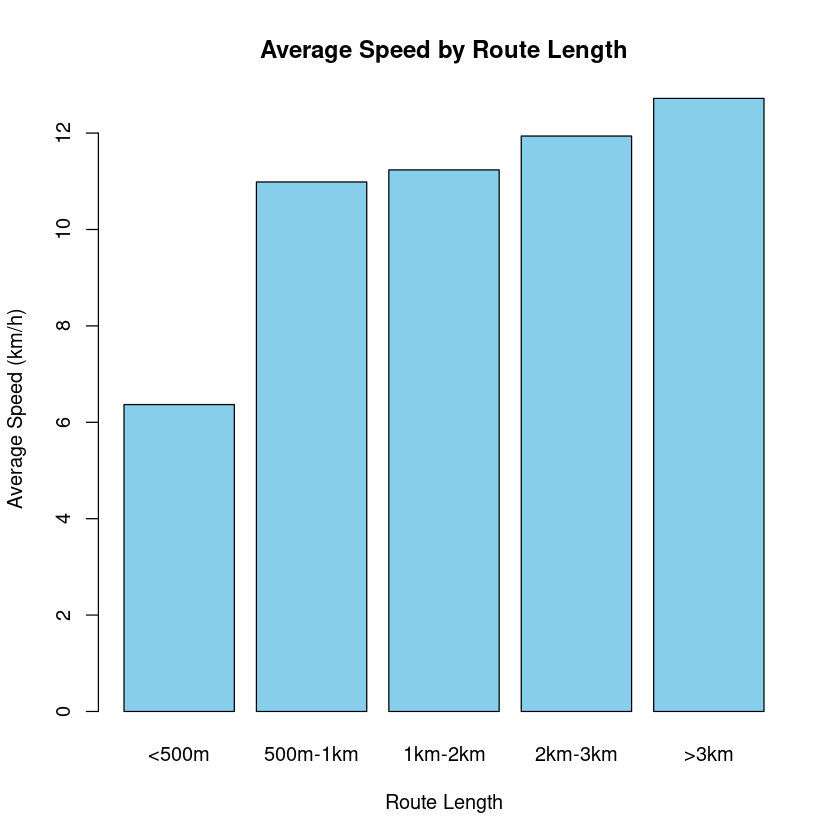

In [15]:
list_x <- c("<500m", "500m-1km", "1km-2km", "2km-3km", ">3km")
list_speeds <- list(
    speeds[distance < 0.5],
    speeds[0.5 < distance & distance < 1],
    speeds[1 < distance & distance < 2],
    speeds[2 < distance & distance < 3],
    speeds[distance > 3]
)

avg_speeds <- c()
for (s in list_speeds) {
    avg_speeds <- c( avg_speeds, mean(s) )
}

barplot(
    avg_speeds, 
    names.arg=list_x,
    col="skyblue",
    main="Average Speed by Route Length",
    xlab="Route Length",
    ylab="Average Speed (km/h)"
)

(8.1) Find the most common start station and the least popular end station

In [16]:
sorted_stations <- sort(table(df$start.station.name))
least_common_station <- sorted_stations[1]
most_common_station <- sorted_stations[length(sorted_stations)]

msg1 <- paste("The most common station is", names(most_common_station), "with", most_common_station, "users.")
msg2 <- paste("The least common station is", names(least_common_station), "with", least_common_station, "users.")

print(msg1)
print(msg2)

[1] "The most common station is Grove St PATH with 17902 users."
[1] "The least common station is JCBS Depot with 29 users."


(8.2) Find the three most common routes (start and end station) and the three least popular ones

In [17]:
sorted_routs <- sort(table(paste(df$start.station.name, df$end.station.name, sep=" => ")))
len_routs <- length(sorted_routs)

least_common_routs <- sorted_routs[1:3]
most_common_routs <- sorted_routs[len_routs:(len_routs-2)]

cat("Least common routes:", end="\n")
for (i in 1:3) {
    msg <- paste(names(least_common_routs)[i], " (", least_common_routs[i], ")", sep="")
    cat(msg, end="\n")
}
cat("\nMost common routes:", end="\n")
for (i in 1:3) {
    msg <- paste(names(most_common_routs)[i], " (", most_common_routs[i], ")", sep="")
    cat(msg, end="\n")
}

Least common routes: 
5 Corners Library => Dixon Mills (1) 
5 Corners Library => Grand St (1) 
Astor Place => Brunswick & 6th (1) 

Most common routes: 
Hamilton Park => Grove St PATH (3037) 
Grove St PATH => Hamilton Park (2318) 
Brunswick & 6th => Grove St PATH (1916) 


# Exercise 2 - Parallel pixelated-sensors
A detector designed for charge identification of incoming particles consists of two parallel planes, each composed of an 8 × 8 array of pixelated sensors. The collected data is stored in the file available in the repository https://drive.google.com/file/d/1dYPF5tL3qnBmTVbawyKbPOQooi_CCElV/view?usp=sharing, where:
- The first 64 columns correspond to the response of the pixels in the upstream matrix.
- The next 64 columns correspond to the response of the pixels in the downstream matrix.

Each pixel is indexed according to the following formula:

    Pixel Index = Row + Column × Ncols

where Ncols = 8 is the total number of columns in the matrix.

(1) For each event and for each 8 × 8 matrix, perform the following steps:
- Check for missing values in the dataset and handle them appropriately.
- Determine the maximum and second maximum pixel values.
- Identify the corresponding pixel indices.

In [18]:
df <- read.csv("data/l2tree_maxedeptrack_str_20241119_072440_BTff3_ThetaMax60_TrgFlgAll_codver3_onlyMTX.csv")
upstream <- df[,1:64]
downstream <- df[,65:(65+63)]

In [19]:
# checking for missing values
na_in_upstream <- sum(is.na(upstream))
na_in_downstream <- sum(is.na(downstream))
if (na_in_upstream == 0 & na_in_downstream == 0) {
    cat("There are no missing values.\n")
}

# identify maximum and second maximum indices
up_ordered_ix <- apply(upstream, 1, function(x){order(x, decreasing=TRUE)[1:2]})
down_ordered_ix <- apply(downstream, 1, function(x){order(x, decreasing=TRUE)[1:2]})

# determine maximum and second maximum values
up_best_values <- c()
up_best_values2 <- c()
for (i in 1:nrow(upstream)) {
    up_best_values <- c(up_best_values, upstream[i,up_ordered_ix[1,i]])
    up_best_values2 <- c(up_best_values2, upstream[i,up_ordered_ix[2,i]])
}
down_best_values <- c()
down_best_values2 <- c()
for (i in 1:nrow(downstream)) {
    down_best_values <- c(down_best_values, downstream[i,down_ordered_ix[1,i]])
    down_best_values2 <- c(down_best_values2, downstream[i,down_ordered_ix[2,i]])
}

There are no missing values.


(2) Plot the distributions of the indices corresponding to the maximum and second maximum pixel values.

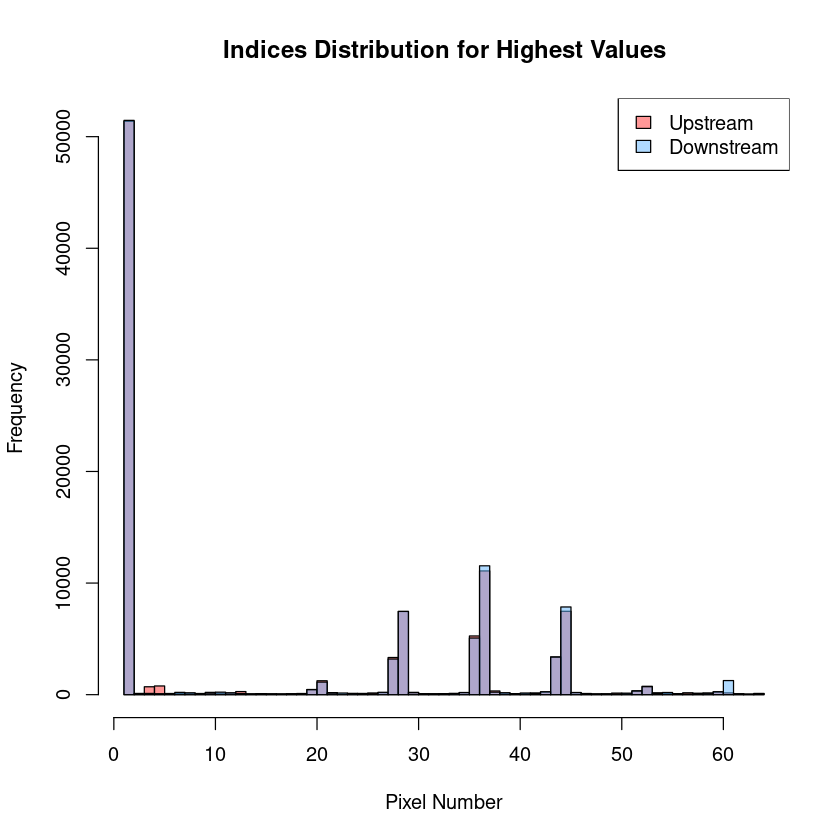

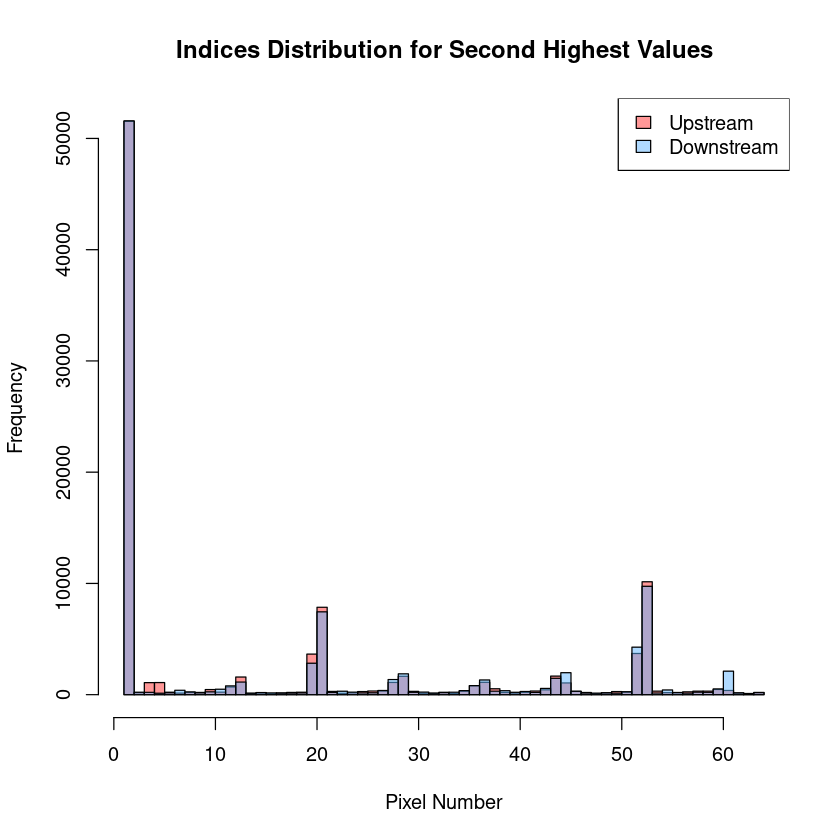

In [20]:
plot_hist(
    up_ordered_ix[1,], 
    down_ordered_ix[1,],
    breaks=64,
    title="Indices Distribution for Highest Values",
    xlab="Pixel Number",
    legend=c("Upstream", "Downstream")
)

plot_hist(
    up_ordered_ix[2,], 
    down_ordered_ix[2,],
    breaks=64,
    title="Indices Distribution for Second Highest Values",
    xlab="Pixel Number",
    legend=c("Upstream", "Downstream")
)

(3) Repeat the same plot but excluding events where the maximum signal is less than 10.

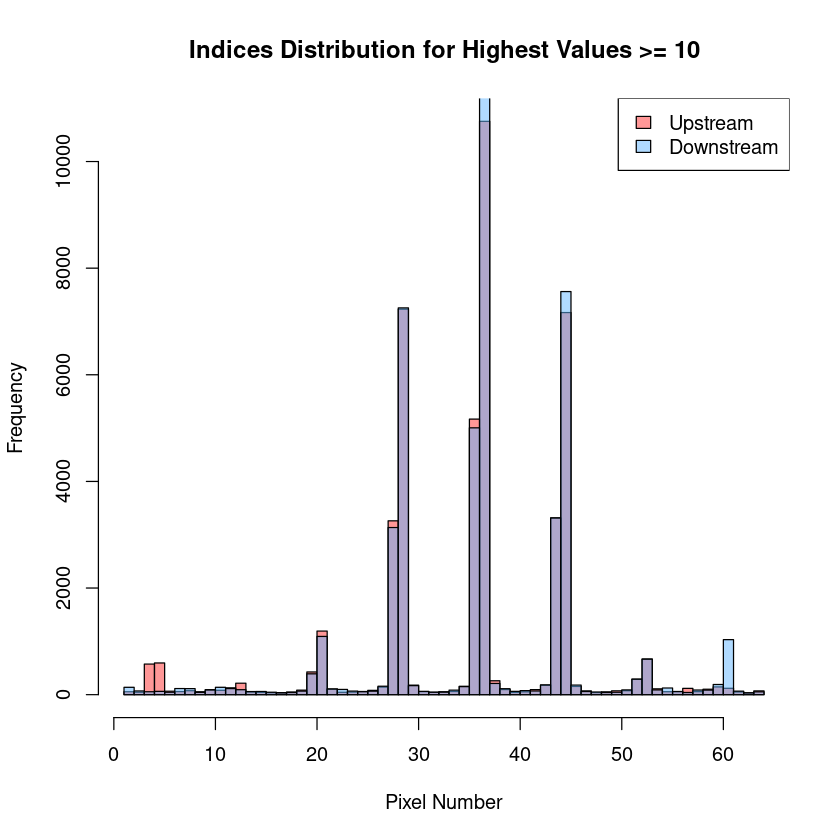

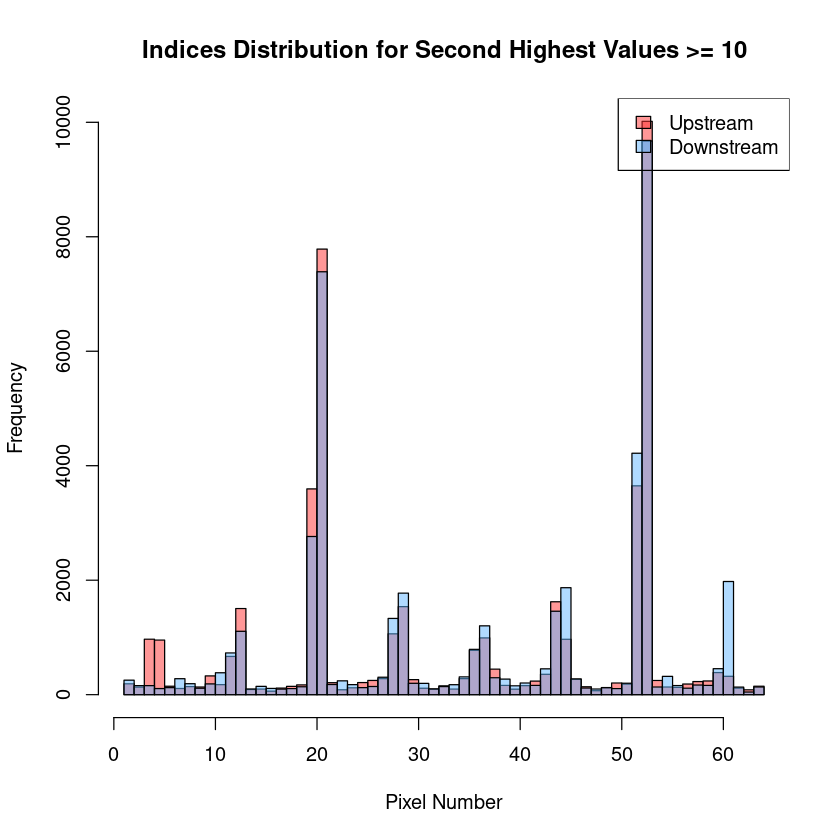

In [21]:
plot_hist(
    up_ordered_ix[1,(up_best_values >= 10)], 
    down_ordered_ix[1,(down_best_values >= 10)],
    breaks=64,
    title="Indices Distribution for Highest Values >= 10",
    xlab="Pixel Number",
    legend=c("Upstream", "Downstream")
)

plot_hist(
    up_ordered_ix[2,(up_best_values >= 10)], 
    down_ordered_ix[2,(down_best_values >= 10)],
    breaks=64,
    title="Indices Distribution for Second Highest Values >= 10",
    xlab="Pixel Number",
    legend=c("Upstream", "Downstream")
)

(4) Compute event-by-event, the ratio between the second and first maximum values.

In [22]:
ratio_up <- up_best_values2 / up_best_values
ratio_down <- down_best_values2 / down_best_values

(5) Only consider events where both values are greater than zero. Plot the distribution of this ratio in four different signal ranges:
-  10 ≤ Max < 300
- 300 ≤ Max < 1200
- 1200 ≤ Max < 30000
- Max ≥ 30000

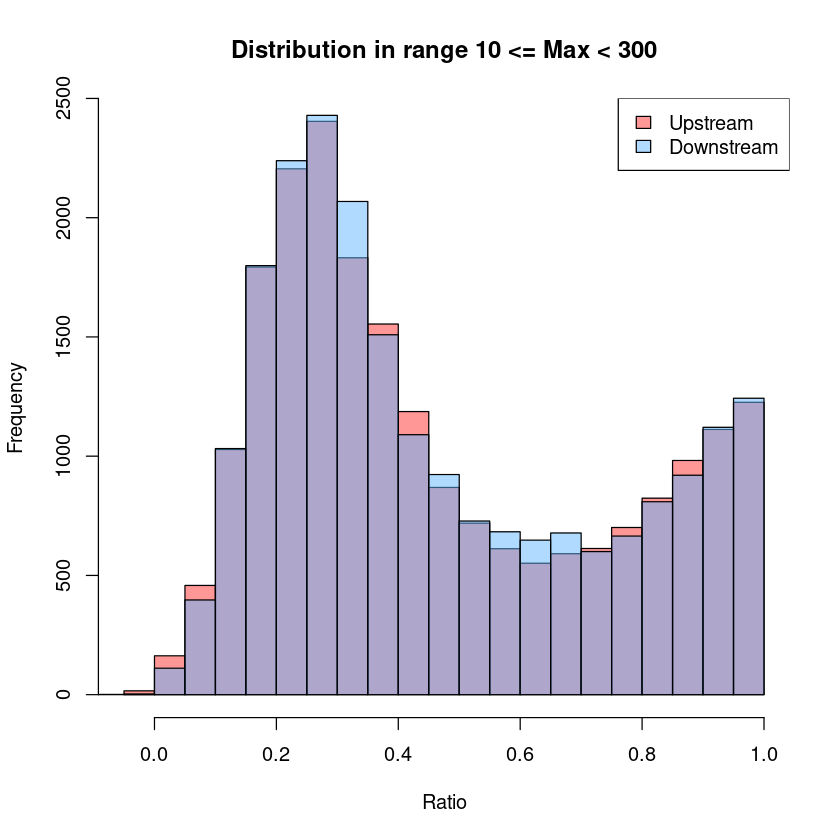

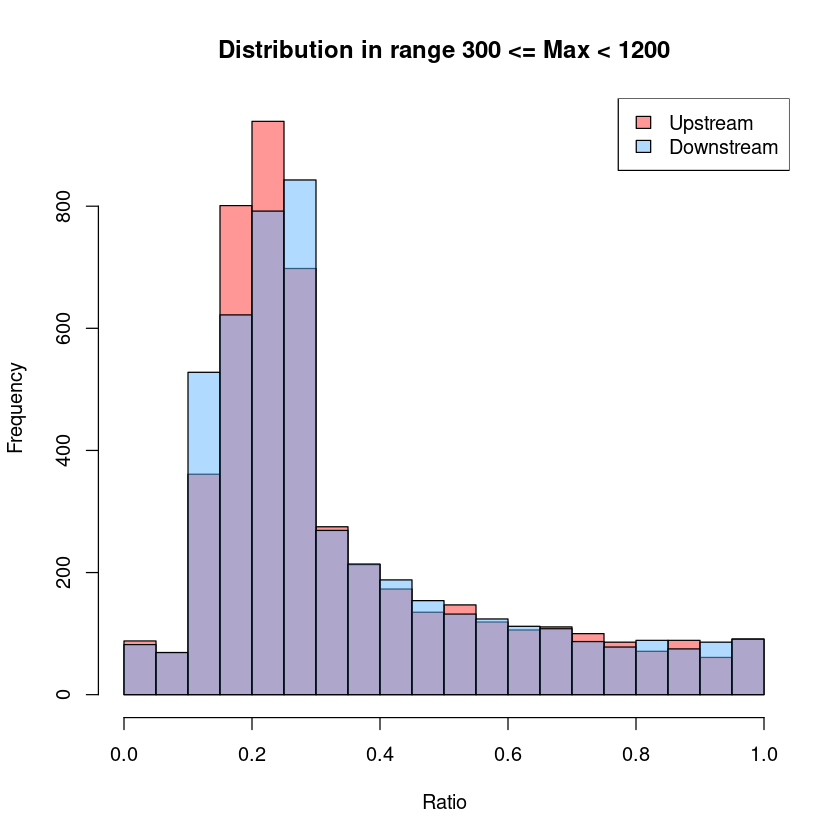

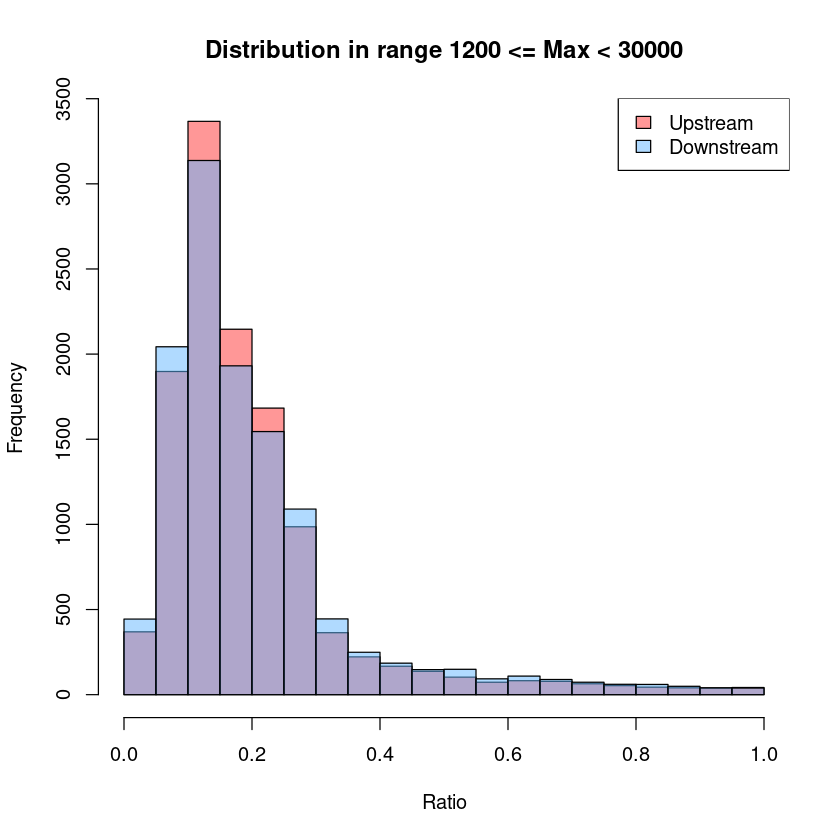

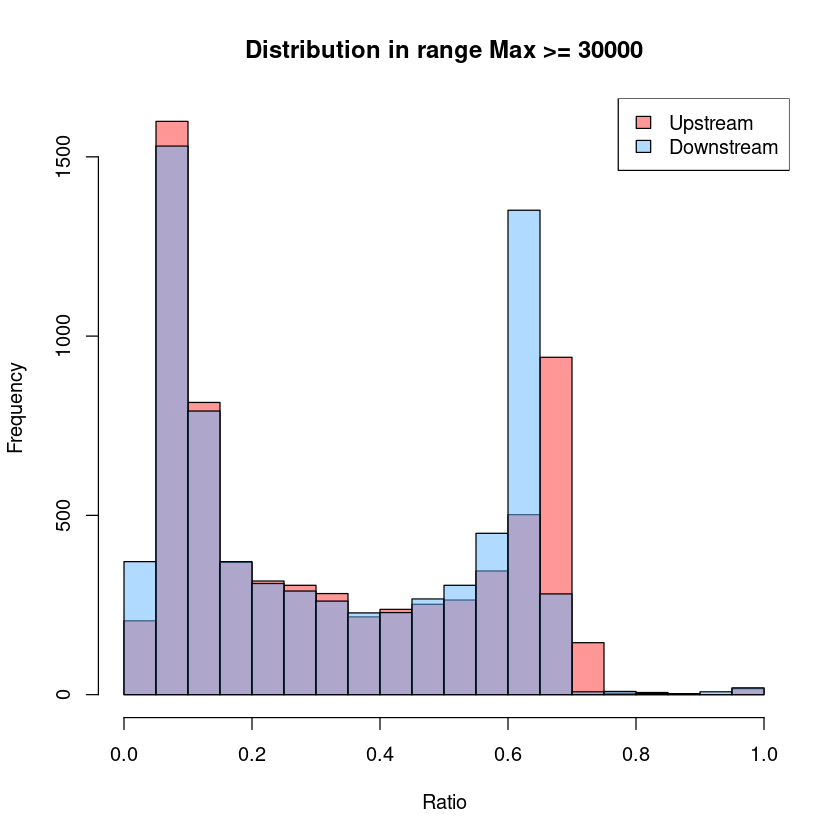

In [23]:
ratio_up_ranges <- list(
    ratio_up[10 <= up_best_values & up_best_values < 300],
    ratio_up[300 <= up_best_values & up_best_values < 1200],
    ratio_up[1200 <= up_best_values & up_best_values < 30000],
    ratio_up[up_best_values >= 30000]
)

ratio_down_ranges <- list(
    ratio_down[10 <= down_best_values & down_best_values < 300],
    ratio_down[300 <= down_best_values & down_best_values < 1200],
    ratio_down[1200 <= down_best_values & down_best_values < 30000],
    ratio_down[down_best_values >= 30000]
)

list_titles <- c(
    "Distribution in range 10 <= Max < 300",
    "Distribution in range 300 <= Max < 1200",
    "Distribution in range 1200 <= Max < 30000",
    "Distribution in range Max >= 30000"
)

for (i in 1:4) {
    plot_hist(
        ratio_up_ranges[[i]], 
        ratio_down_ranges[[i]],
        breaks=20,
        title=list_titles[i],
        xlab="Ratio",
        legend=c("Upstream", "Downstream")
    )
}

(6) Generate heatmaps illustrating the spatial distribution (in terms of row and column) of:
- The maximum pixel indices.
- The second maximum pixel indices.

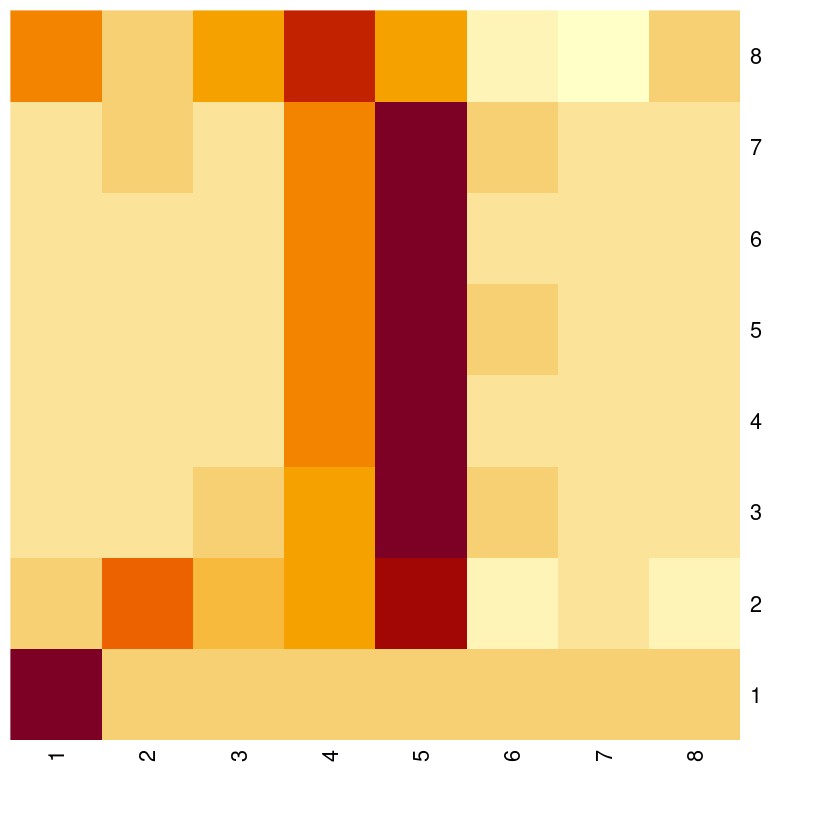

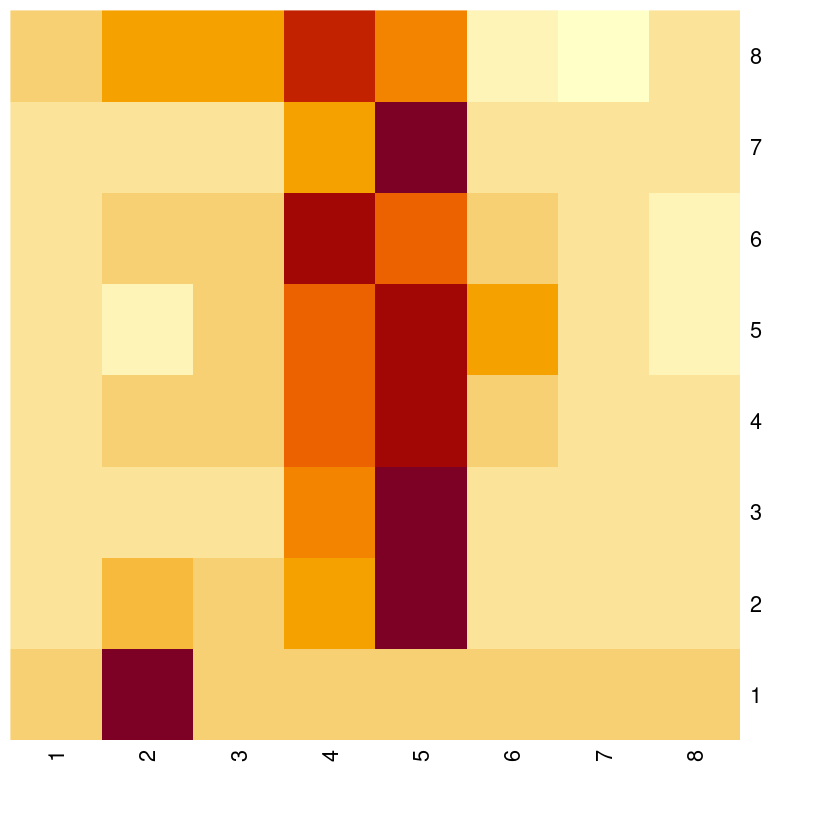

In [24]:
heatmap(
    t(matrix(table(up_ordered_ix[1,]), nrow=8)),
    Rowv=NA, Colv=NA
)

heatmap(
    t(matrix(table(up_ordered_ix[2,]), nrow=8)),
    Rowv=NA, Colv=NA
)

(7) Count the number of times the pixel index of the maximum signal in the upstream matrix matches that of the downstream matrix. Create a bar plot, considering only events where the maximum value exceeds 10.

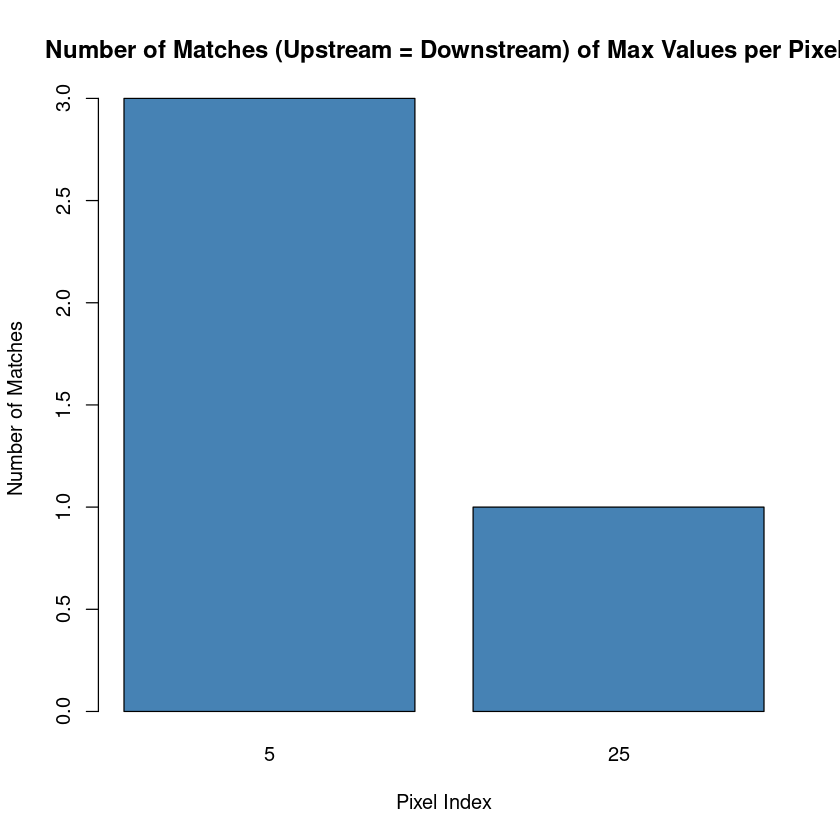

In [25]:
bool_same_values <- (up_best_values > 10) & (up_best_values == down_best_values)

barplot(
    table(up_ordered_ix[1,][bool_same_values]),
    col="steelblue", 
    main="Number of Matches (Upstream = Downstream) of Max Values per Pixel",
    xlab="Pixel Index", ylab="Number of Matches"
)

(8) Identify the four most frequently occurring pairs of maximum pixel indices (Max Index Upstream, Max Index Downstream)

In [26]:
sorted_max_pairs <- sort(table(paste(up_best_values, down_best_values, sep=";")), decreasing=TRUE)

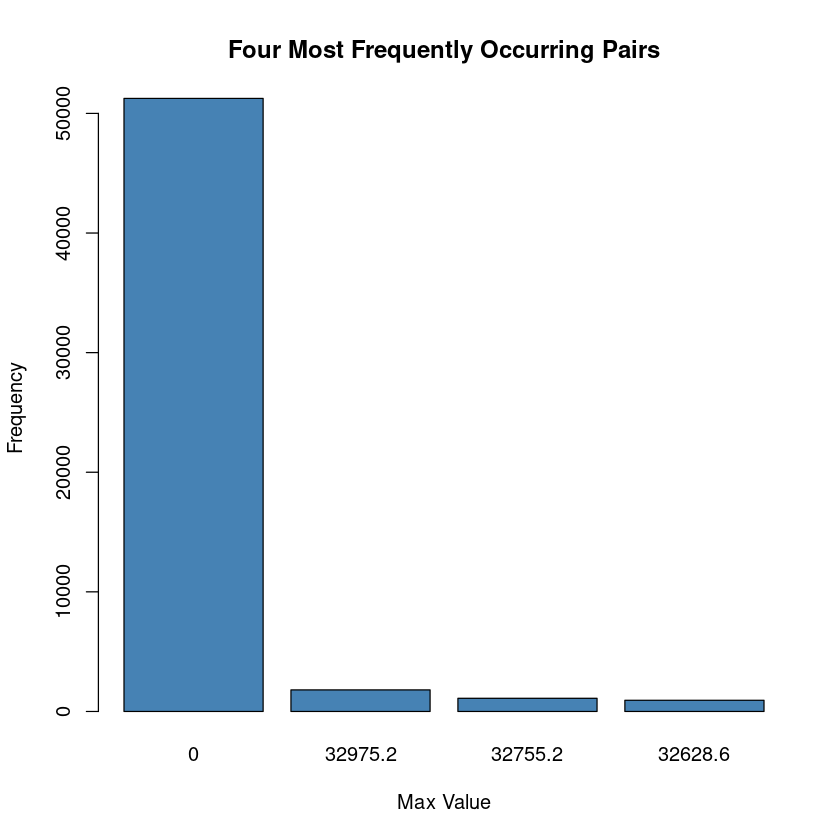

In [27]:
list_names <- c()
for (label in names(sorted_max_pairs[1:4])) {
    list_names <- c(list_names, strsplit(label, ";")[[1]][1])
}

barplot(
    sorted_max_pairs[1:4],
    names.arg=list_names, col="steelblue",
    xlab="Max Value", ylab="Frequency",
    main="Four Most Frequently Occurring Pairs"
)